In [1]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import glob
import random
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import string
from datasets import Dataset

import albumentations
import tensorflow as tf

from transformers import AutoImageProcessor, AutoModelForObjectDetection

In [2]:
if tf.config.list_physical_devices('GPU'):
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)

    # 获取GPU的最大内存使用量（以字节为单位）
    max_memory_allocated = tf.config.experimental.get_memory_usage('GPU:0')

0

# finetune on real data

# TODO: Replace the following paths to use new labeled examples for any task that you'd like

In [3]:
train_images_folder = 'MM_CV_data/text_detection/'
train_annotations_file = 'MM_CV_data/text_detection/result.json'

test_images_folder = 'MM_CV_data/text_detection/test/'
test_annotations_file = 'MM_CV_data/text_detection/test/result.json'

In [4]:
def get_datasets(annotations_file, images_folder):
    
    with open(annotations_file) as fp:
        annotations = json.loads(fp.read())
    
    elements = []
    
    for i, image_description in enumerate(annotations['images']):
    
        img = Image.open(os.path.join(images_folder, image_description['file_name']))
    
        objects = {'id':[], 
                   'area': [],
                   'bbox': [],
                   'category': []}
        
        for j, ann_description in enumerate(annotations['annotations']):
    
            if ann_description['image_id'] == image_description['id']:
    
                objects['id'].append(ann_description['id'])
                objects['area'].append(ann_description['area'])
                objects['bbox'].append(ann_description['bbox'])
                objects['category'].append(ann_description['category_id'])
        
        
        el = {'image_id': image_description['id'],
              'image': img,
              'width': image_description['width'],
              'height': image_description['height'],
              'objects': objects
        }
    
        elements.append(el)

    return Dataset.from_list(elements)

In [5]:
dataset_train = get_datasets(train_annotations_file, train_images_folder)
dataset_test = get_datasets(test_annotations_file, test_images_folder)

In [6]:
dataset_train

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 9
})

In [7]:
print(dataset_test[0])

{'image_id': 0, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2275x1945 at 0x1ECC30C9F10>, 'width': 2275, 'height': 1945, 'objects': {'area': [19311.141977107185, 64301.1899687825, 69352.57152965663, 140997.79005202916, 102186.55167533824, 396073.66343392315, 184318.74064516125], 'bbox': [[323.74838709677425, 27.60645161290323, 183.20645161290327, 105.40645161290324], [281.083870967742, 255.98709677419356, 308.6903225806451, 208.3032258064516], [968.7354838709678, 446.7225806451613, 358.88387096774204, 193.2451612903226], [1621.251612903226, 572.2064516129032, 456.7612903225807, 308.69032258064516], [439.1935483870968, 981.283870967742, 424.13548387096785, 240.92903225806458], [1099.2387096774196, 1031.4774193548387, 499.425806451613, 793.0580645161291], [165.63870967741934, 1611.2129032258067, 622.4000000000001, 296.14193548387084]], 'category': [0, 0, 0, 0, 0, 0, 0], 'id': [0, 1, 2, 3, 4, 5, 6]}}


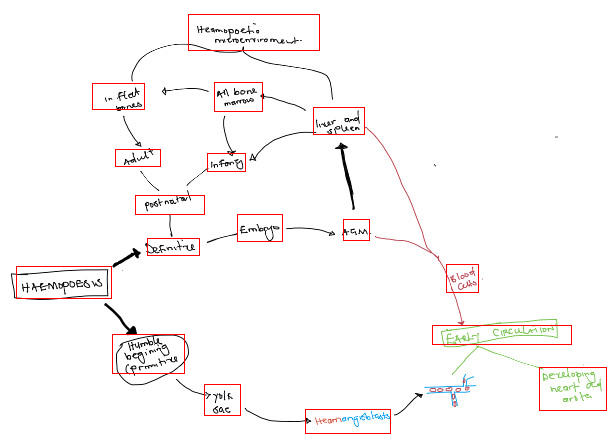

In [8]:
image = dataset_train[0]["image"].copy()
annotations = dataset_train[0]["objects"]
draw = ImageDraw.Draw(image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)

image

# TODO: Set the data augmentation preferences. Current ones showed good results in previous trainings

In [9]:
checkpoint = "hustvl/yolos-tiny"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, size=1024, longest_edge=1024)

transform = albumentations.Compose(
    [
        albumentations.Resize(1024, 1024),
        albumentations.RandomCrop(width=900, height=900),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

not_transform = albumentations.Compose(
    [
        albumentations.Resize(1024, 1024),
        #albumentations.RandomCrop(width=450, height=450),
        #albumentations.HorizontalFlip(p=1.0),
        #albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [10]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [11]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
       
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_not_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = not_transform(image=image, bboxes=objects["bbox"], category=objects["category"])
       
        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [12]:
train = dataset_train.with_transform(transform_aug_ann)
eval = dataset_test.with_transform(transform_not_aug_ann)

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    #encoding = image_processor.pad(pixel_values, return_tensors="pt")
    #encoding = image_processor.preprocess(pixel_values, do_normalize=True, do_resize=False, return_tensors="pt")
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    #batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [14]:
id2label={0:'drawing'}
label2id={'drawing':0}

In [16]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# TODO: Set the hyperparameters. learning rate is probably the most impacful. Max Batch size will depend on GPU capabilities. Weight decay can help regularization. More info about these arguments can be found in https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

In [17]:
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(device)


cuda


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="training",
    per_device_train_batch_size=1,
    num_train_epochs=100,
    fp16=True,
    save_steps=200,
    eval_steps = 100,
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=5e-4,
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=False,
    evaluation_strategy="steps",
    warmup_steps=500,
    lr_scheduler_type = 'linear'
)

True


0

In [21]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=100,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_str

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    eval_dataset=eval,
    tokenizer=image_processor,
)

trainer.train()

C:\Users\Aliphraim\anaconda3\envs\for_Tang_conv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

# TODO: once trained, pick a checkpoint (chechpoints are saved to your disk) to make inference

In [27]:
last_checkpoint = "training/checkpoint-600"

image_processor = AutoImageProcessor.from_pretrained(last_checkpoint)
model = AutoModelForObjectDetection.from_pretrained(last_checkpoint)

In [33]:
def show_predictions(image, threshold=0.9):
    
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    target_sizes = tf.convert_to_tensor([image.size[::-1]], dtype=tf.int32)

    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    draw = ImageDraw.Draw(image)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
                f"Detected {model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"
        )
        draw.rectangle(box, outline="red", width=1)
    
    return image

### TODO: just pick an image from the test set and a threshold to see results

Detected drawing with confidence 0.816 at location [301.84, 28.1, 516.99, 143.84]
Detected drawing with confidence 0.754 at location [869.39, 435.77, 1249.49, 668.57]
Detected drawing with confidence 0.729 at location [1211.59, 1513.64, 1562.29, 1658.22]
Detected drawing with confidence 0.743 at location [1220.61, 1341.68, 1537.07, 1467.84]
Detected drawing with confidence 0.728 at location [333.94, 1697.85, 771.12, 1841.36]
Detected drawing with confidence 0.749 at location [109.03, 1631.65, 379.5, 1751.04]
Detected drawing with confidence 0.723 at location [1201.48, 1125.19, 1516.87, 1273.04]
Detected drawing with confidence 0.823 at location [1710.66, 719.56, 2070.99, 857.12]
Detected drawing with confidence 0.804 at location [1733.9, 590.83, 2010.99, 725.89]
Detected drawing with confidence 0.765 at location [231.54, 60.87, 600.91, 493.82]
Detected drawing with confidence 0.823 at location [1175.0, 1480.09, 1555.72, 1653.25]
Detected drawing with confidence 0.844 at location [1682.

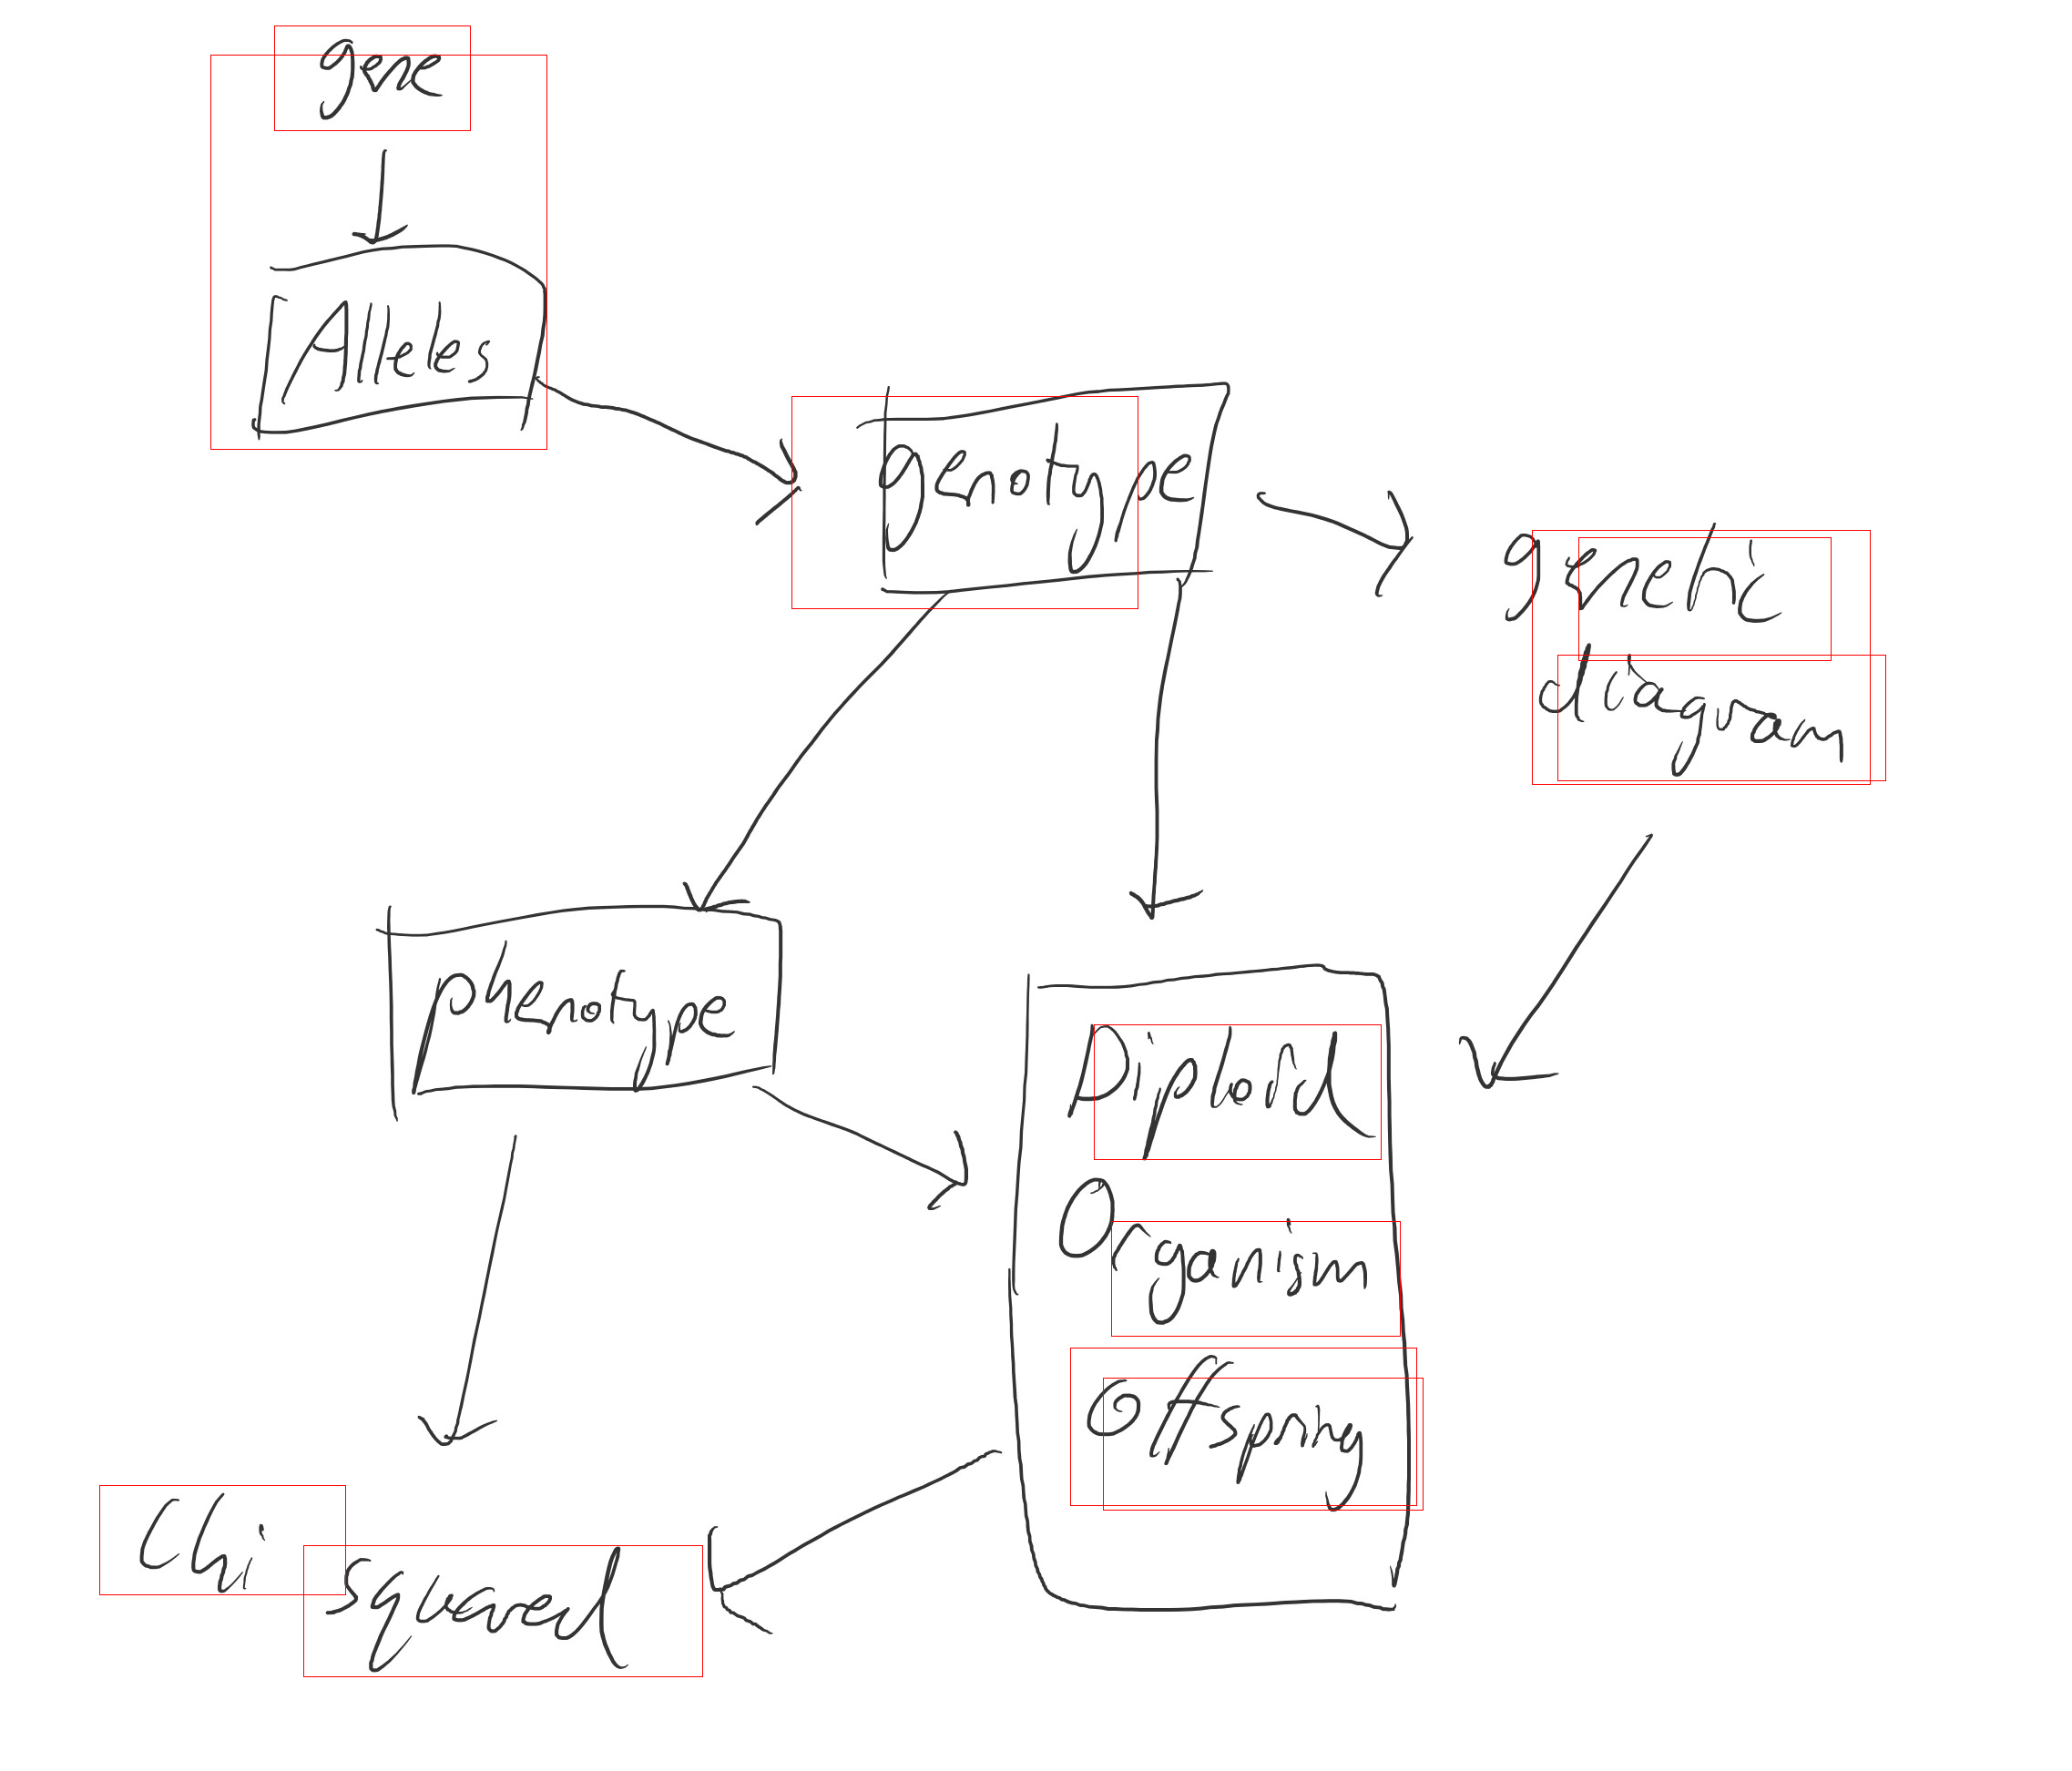

In [36]:
show_predictions(dataset_test[0]['image'], 0.7)